In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import linregress 
import numpy as np
import math
from pathlib import Path
from scipy.odr import *


Calibration coefficient calculated with a linear regression of the 3 datasets combined

In [229]:
def DataAnalysis(folderpath,outputpath,FW,wavelength):
    Ttotal = pd.DataFrame()
    fig, ax = plt.subplots()
    for filename in os.listdir(folderpath):
        if FW in filename and wavelength in filename:
            #Read and store the data
            T = pd.read_csv(f'{folderpath}/{filename}',delimiter ='\t',header=None)
            T.columns = ['date-time', 'L', 'meanPM', 'stdPM', 'meanRefPD', 'stdRefPD', 'Temp', 'RH', 'samples']
            Ttotal = pd.concat([Ttotal,T])
            #Plot each dataset
            ax.errorbar(T['meanRefPD'], T['meanPM'],  yerr=T['stdPM'], xerr=T['stdRefPD'], fmt='.', markersize=5, linewidth=1, zorder=1)

    #linear regression with all 3 datasests

    def f(B, x):
        '''Linear function y = m*x + b'''
        # B is a vector of the parameters.
        # x is an array of the current x values.
        # x is in the same format as the x passed to Data or RealData.
        #
        # Return an array in the same format as y passed to Data or RealData.
        return B[0]*x + B[1]

    linear = Model(f)
    #Remove zeroes in std
    Ttotal['stdPM'] += 1e-10
    Ttotal['stdRefPD'] += 1e-10
    mydata = RealData(Ttotal['meanRefPD'], Ttotal['meanPM'], sx=Ttotal['stdRefPD'], sy=Ttotal['stdPM'])
    myodr = ODR(mydata, linear, beta0=[3.e-4, 0.])
    myoutput = myodr.run()
    slope = myoutput.beta[0]
    std = myoutput.sd_beta[0]
    intercept = myoutput.beta[1]


    #print and plot the result
    print(f'Wavelength = {wavelength}, {FW}, CC found as ODR of all the dataset = {slope} +/- {std} in W/V')
    ax.plot(Ttotal['meanRefPD'], intercept + slope*Ttotal['meanRefPD'], 'r', label='fitted line', alpha = 0.7, linewidth=1)
    ax.set_ylabel('Mean Optical Power (W)')
    ax.set_xlabel('Mean ref PD (V)')
    ax.grid()
    ax.text(0.1,0.9,f'CC={slope:.5e} +/- {std:.1e} ',verticalalignment='top', bbox=dict(facecolor='white', alpha=1), transform=ax.transAxes)
    plt.title(f'ODR all datasets {FW} and wavelwngth {wavelength}')
    fig.tight_layout()
    fig.savefig(f'{outputpath}/CalibrationCoeficient_{FW}_{wavelength}.png',dpi=199)
    return slope, std
    #plt.close()

Wavelength = 532, FW1, CC found as ODR of all the dataset = 7.386465992741048e-05 +/- 3.561506223016436e-07 in W/V
Wavelength = 1064, FW1, CC found as ODR of all the dataset = 5.239189939625332e-05 +/- 1.2863513764931814e-08 in W/V
Wavelength = 532, FW4, CC found as ODR of all the dataset = 0.0004277406603849375 +/- 2.509358404144935e-07 in W/V
Wavelength = 1064, FW4, CC found as ODR of all the dataset = 0.0003459180875195714 +/- 7.143240732049749e-08 in W/V


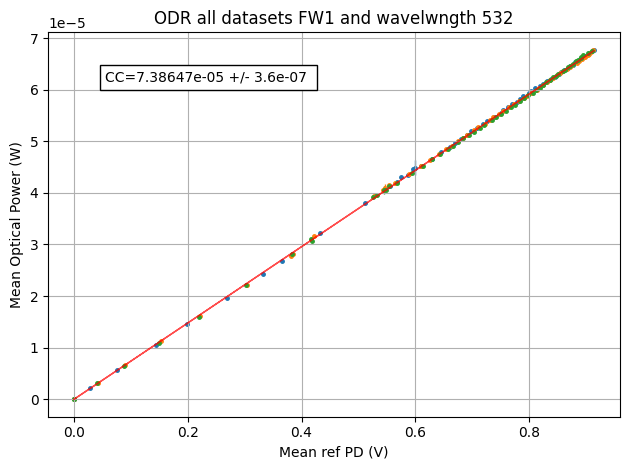

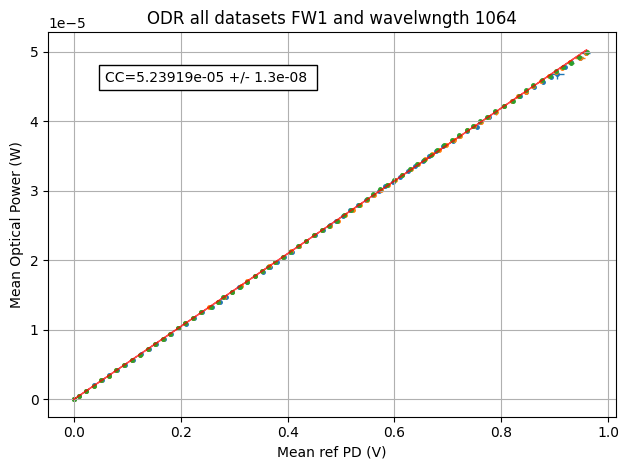

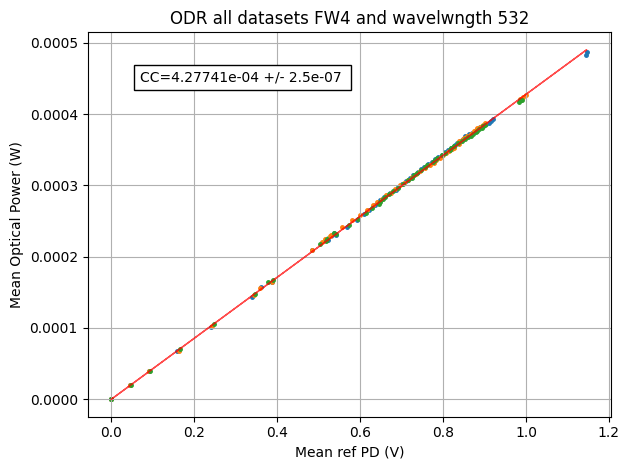

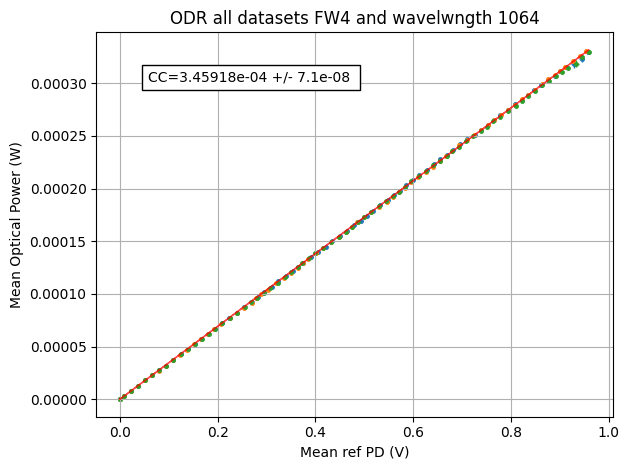

In [230]:
folderpath = './calibration_10062025'
outputpath = './Output'

FW1_532 = DataAnalysis(folderpath,outputpath,"FW1","532")
FW1_1064 = DataAnalysis(folderpath,outputpath,"FW1","1064")
FW4_532 =  DataAnalysis(folderpath,outputpath,"FW4","532")
FW4_1064 = DataAnalysis(folderpath,outputpath,"FW4","1064")

results = pd.DataFrame({'FW':['FW1','FW1','FW4','FW4'],
                        'Wavelength':['532','1064','532','1064'],
                        'CC':[FW1_532[0],FW1_1064[0],FW4_532[0],FW4_1064[0]],
                        'CCstd':[FW1_532[1],FW1_1064[1],FW4_532[1],FW4_1064[1]],    
                         })

results.to_csv('ResultsSetup1.csv')
